
# Reconocimiento de Patrones

## Licenciatura en Ciencias de la Computación

### Proyecto Final
Profesor: Julio Waissman Vilanova

Integrantes:

Adrian L. Soto T.  

Hugo A. Eguino A.



En esta libreta analizaremos y experimentaremos con los datos de la base de datos "Real or Not?", tomada de kaggle. Está compuesta por tweets sobre desastres, y están clasificados como desastres reales o falsos.

Elegimos esta base de datos, ya que es algo muy importante para la sociedad poder monitorar la aparición de desastres mediante las redes sociales, pues aquí es donde más rápido se comparten. Estos tweets tienen un gran impacto en las redes sociales, por lo que tambien llegan a tener un gran impacto en toda la sociedad. Poder detectar desastres reales por medio de redes sociales, será beneficioso para todos.

El valor de 1 en la columna target significa que es un desastre real. El valor de 0 significa que es un desastre falso.

Empezaremos importando todos los módulos que necesitaremos.

In [703]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from collections import Counter
import re
import string
from gensim.parsing.preprocessing import remove_stopwords
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from scipy import sparse
import nltk
nltk.download('wordnet')
nltk.download('punkt')
%matplotlib inline 
sns.set(color_codes=True)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Leemos los archivos csv de la base de datos y vemos como están compuestos.

In [704]:
tweets_train = pd.read_csv("train.csv")
tweets_test = pd.read_csv("test.csv") 
print("Forma de los datos de prubea: " + str(tweets_test.shape))
print("Forma de los datos de entrenamiento: " + str(tweets_train.shape))
tweets_train.head(5)

Forma de los datos de prubea: (3263, 4)
Forma de los datos de entrenamiento: (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Dos columnas de los datos pueden tener valor nulo. Analizaremos nuestros datos para ver cuántos datos nulos tenemos.

In [705]:
print("Cantidad de datos válidos por columna: \n" + str(tweets_train.count()) + "\n")
print("Cantidad de datos nulos por columna: \n" + str(tweets_train.isnull().sum()))

Cantidad de datos válidos por columna: 
id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64

Cantidad de datos nulos por columna: 
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


En Twitter la localización es puesta por el usuario, no tiene que ser una ubicación real, puede ser cualquier cosa. Además, gran parte de los tweets en nuestra base de datos no cuentan con localización. Por esto, se considera que esta columna de información será de poca ayuda y es mejor quitarla.

In [706]:
tweets_train = tweets_train.drop(["location"], axis=1)
tweets_test = tweets_test.drop(["location"], axis=1)
tweets_train.head(5)

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Aún nos quedan valores nulos en la columna de keyword. Podemos reemplazarlos o quitar esos renglones. En este caso, como es un número muy pequeño, 61 valores nulos comparado con los más de 7500 datos, decidimos eliminar esos renglones.

In [707]:
tweets_train = tweets_train.dropna() 
print("Cantidad de datos válidos por columna: \n" + str(tweets_train.count()) + "\n")
print("Cantidad de datos nulos por columna: \n" + str(tweets_train.isnull().sum()))
tweets_train.head()

Cantidad de datos válidos por columna: 
id         7552
keyword    7552
text       7552
target     7552
dtype: int64

Cantidad de datos nulos por columna: 
id         0
keyword    0
text       0
target     0
dtype: int64


,id,keyword,text,target
31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,Crying out for more! Set me ablaze,0
35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


Ahora hay que explorar nuestros datos. Empezemos viendo la cantidad de tweets sobre desastres falsos y la cantidad de tweets sobre desastres reales


Tweets de desastres falsos target = 0
Tweets de desastres reales target = 1 



Text(0, 0.5, 'Número de tweets')

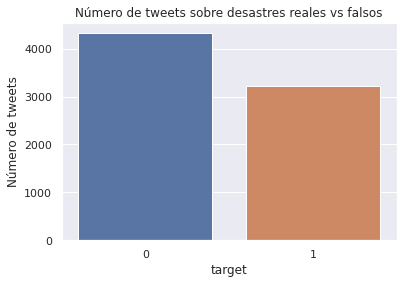

In [708]:
print("Tweets de desastres falsos target = 0")
print("Tweets de desastres reales target = 1 \n")

plt.plot()
sns.countplot(x="target", data=tweets_train)
plt.title("Número de tweets sobre desastres reales vs falsos")
plt.ylabel("Número de tweets")

Se observa que en nuestro datos contamos con una cantidad mayor de tweets sobre desastres falsos que tweets sobre desastres reales. Lo que es de esperarse.

Considerando que es común que los tweets sobre desastres reales tienden a ser más descriptivos, pudiendo ser más largos. Agregaremos una columna con el tamaño del tweet en caracteres.

In [709]:
tweets_train['size'] = tweets_train.text.apply(len)
tweets_train.head()

,id,keyword,text,target,size
31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55
32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0,67
33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82
34,52,ablaze,Crying out for more! Set me ablaze,0,34
35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76


Graficaremos la distribucion de los tweets sobre desastre falsos y los sobre desastres reales, de acuerdo al tamaño de caracteres. Esto para observar si se puede notar algo interesante.

Text(0.5, 0, 'Tamaño de los tweets en caracteres')

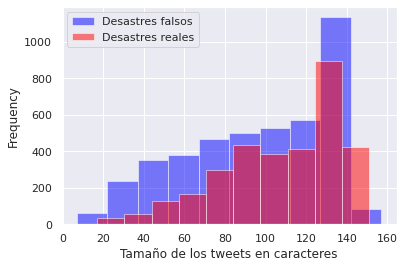

In [710]:
plt.figure()
tweets_train[tweets_train.target==0]['size'].plot(kind='hist', color='blue', label='Desastres falsos', alpha=0.5)                           
tweets_train[tweets_train.target==1]['size'].plot(kind='hist', color='red', label='Desastres reales', alpha=0.5)                                  
plt.legend()
plt.xlabel("Tamaño de los tweets en caracteres")

In [711]:
#Tweets de desastres falsos
print("Descripción estatística sobre el tamaño en los tweets de desastres falsos")
tweets_train[tweets_train.target==0]['size'].describe()

Descripción estatística sobre el tamaño en los tweets de desastres falsos


count    4323.000000
mean       96.017349
std        35.613606
min         7.000000
25%        68.000000
50%       101.000000
75%       130.000000
max       157.000000
Name: size, dtype: float64

In [712]:
#Tweets de desastres reales
print("Descripción estatística sobre el tamaño en los tweets de desastres reales")
tweets_train[tweets_train.target==1]['size'].describe()

Descripción estatística sobre el tamaño en los tweets de desastres reales


count    3229.000000
mean      108.270672
std        29.215589
min        17.000000
25%        88.000000
50%       115.000000
75%       136.000000
max       151.000000
Name: size, dtype: float64

En la gráfica se da a notar que los tweets sobre desastres falsos muestran una frecuencia más alta en los tweets de poco tamaño, a diferencia de los tweets sobre desastres reales que tienen una frecuencia baja en estos tamaños.
Con la información de las estadítsticas vemos que los tweets de desastres reales tienden a un tamaño más grande que los de desastres falsos. 


Es momento de ver cuáles son las palabras más comunes en nuestros tweets.

In [713]:
tweets_por_palabras = tweets_train['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in tweets_por_palabras for item in sublist])
top_words = pd.DataFrame(top.most_common(20))
top_words.columns = ['Palabra','Conteo']
top_words.style.background_gradient(cmap='Greens')

,Palabra,Conteo
0,the,2562
1,a,1831
2,to,1797
3,in,1737
4,of,1711
5,and,1294
6,I,1188
7,for,815
8,is,804
9,on,768


Se observa que hay muchas palabras que no aportan nada, porque son muy comunes. También se repiten por las mayúsculas.
Necesitamos limpiar los tweets, quitar enlaces, quitar signos, pasarlos a minúsculas, y quitar palabras comúnes del inglés, conocidas como "stopwords"

In [714]:
print("Tweets antes de la limpieza")
tweets_train.head()

Tweets antes de la limpieza


,id,keyword,text,target,size
31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55
32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0,67
33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82
34,52,ablaze,Crying out for more! Set me ablaze,0,34
35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76


In [715]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    return text

tweets_train['text'] = tweets_train['text'].apply(lambda x:clean_text(x))
tweets_test['text'] = tweets_test['text'].apply(lambda x:clean_text(x))
print("Tweets después de la limpieza")
tweets_train.head()

Tweets después de la limpieza


,id,keyword,text,target,size
31,48,ablaze,bbcmtd wholesale markets ablaze,1,55
32,49,ablaze,we always try to bring the heavy metal rt,0,67
33,50,ablaze,africanbaze breaking newsnigeria flag set abla...,1,82
34,52,ablaze,crying out for more set me ablaze,0,34
35,53,ablaze,on plus side look at the sky last night it was...,0,76


Ahora removeremos las palabras comunes, o stopwords

In [716]:
tweets_train['text'] = tweets_train['text'].apply(lambda x:remove_stopwords(x))
tweets_test['text'] = tweets_test['text'].apply(lambda x:remove_stopwords(x))
print("Tweets después de quitar stopwords")
tweets_train.head()

Tweets después de quitar stopwords


,id,keyword,text,target,size
31,48,ablaze,bbcmtd wholesale markets ablaze,1,55
32,49,ablaze,try bring heavy metal rt,0,67
33,50,ablaze,africanbaze breaking newsnigeria flag set abla...,1,82
34,52,ablaze,crying set ablaze,0,34
35,53,ablaze,plus look sky night ablaze,0,76


Después de hacer esto, ya podemos ver las palabras significativas más comunes en nuestros tweets.

In [717]:
tweets_por_palabras = tweets_train['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in tweets_por_palabras for item in sublist])
top_words = pd.DataFrame(top.most_common(20))
top_words.columns = ['Palabra','Conteo']
fig = px.bar(top_words, x="Conteo", y="Palabra", title='Palabras más comunes en los tweets', orientation='h',width=700, height=500, color='Palabra')
fig.show()

Ahora hay que comparar las palabras más comunes en los tweets de desastres reales contra los de desastres falsos

In [718]:
tweets_reales = tweets_train[tweets_train['target']==1]
tweets_falsos = tweets_train[tweets_train['target']==0]

tweets_por_palabras = tweets_reales['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in tweets_por_palabras for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Palabras en desastres reales','Conteo']
temp_positive.style.background_gradient(cmap='Reds')


,Palabras en desastres reales,Conteo
0,news,130
1,disaster,115
2,suicide,107
3,california,106
4,amp,106
5,police,104
6,people,102
7,killed,92
8,like,92
9,hiroshima,85


In [719]:
tweets_por_palabras = tweets_falsos['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in tweets_por_palabras for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Palabras en desastres falsos','Conteo']
temp_positive.style.background_gradient(cmap='Blues')

,Palabras en desastres falsos,Conteo
0,like,251
1,im,240
2,amp,192
3,new,168
4,dont,139
5,body,112
6,video,96
7,people,91
8,love,85
9,2,85


Para usar algún modelo de clasificación, primero necesitamos extraer las características de los textos, vectorizarlos. Para esto utilizamos el vectorizador tfidf, este sirve para determinar que tan relevante es una palabra para un documento en una colección. Consideramos que es mejor opción que solo usar el conteo. 

In [720]:
def get_feature_vector(train_fit):
    vector = TfidfVectorizer()
    vector.fit(train_fit)
    return vector
tf_vector = get_feature_vector(np.array(tweets_train.iloc[:, 2]).ravel())
X = tf_vector.transform(np.array(tweets_train.iloc[:, 2]).ravel())
y = np.array(tweets_train.iloc[:, 3]).ravel()
X

<7552x17732 sparse matrix of type '<class 'numpy.float64'>'
	with 63488 stored elements in Compressed Sparse Row format>

Ya que tenemos nuestros datos vectorizados, los partimos en los de entrenamiento y los de prueba

In [721]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

Estamos listos para usar un modelo. Decidimos usar una regresión logística, porque es mejor empezar con un modelo no muy complicado y rápido.

In [722]:
LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Ya quedó entrenado. Ahora a probarlo con el conjunto de pruebas.

In [723]:
y_predict_lr = LR_model.predict(X_test)
print(accuracy_score(y_test, y_predict_lr))

0.8060886829913965


Obtenemos un puntaje de precisión de 0.8060, está bastante bien, considerando que es una tarea difícil comprender los mensajes de personas en tweets, incluso para otras personas. ¿Podremos mejorarlo? 

Para ver cómo podemos mejorar el modelo, usaremos las curvas de aprendizaje. Aunque en clase las vimos con el error en el eje de las Y, personalmente preferimos verlas con el score, y es así como las utilizaremos.

In [724]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Escalabilidad del modelo")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Rendimiento del modelo")

    return plt




Graficaremos las curvas de aprendizaje, la escalabilidad, y el rendimiento de nuestro modelo.

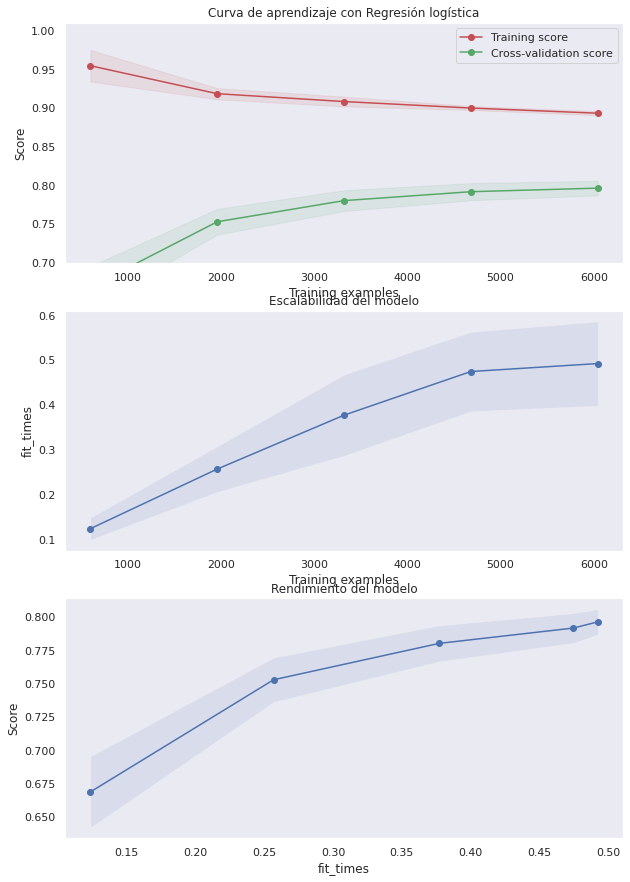

In [725]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
title = "Curva de aprendizaje con Regresión logística"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = LogisticRegression()
plot_learning_curve(estimator, title, X, y, axes=axes, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()

Podemos observar que nuestro problema con este modelo es que tiene una alta varianza. Se observa considerable diferencia entre los score con los datos de entrenamiento que con los de prueba.

Una causa de esto es el sobre aprendizaje. Para reducir la varianza en nuestro modelo necesitamos simplificar nuestro modelo.

Otra solución es obtener más datos. Podemos observar en la gráfica de escalabilidad y de la curva de aprendizaje, que obtener más datos nos ayudará a mejorar el modelo. Pero en este caso no podemos conseguir más datos.

Empezaremos reduciendo la cantidad maxima de caracteristicas que extrae el vectorizador. Antes no tenía límite

In [726]:
def get_feature_vector(train_fit):
    vector = TfidfVectorizer(max_features=10000)
    vector.fit(train_fit)
    return vector
tf_vector = get_feature_vector(np.array(tweets_train.iloc[:, 2]).ravel())
X = tf_vector.transform(np.array(tweets_train.iloc[:, 2]).ravel())
y = np.array(tweets_train.iloc[:, 3]).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
LR_model.fit(X_train, y_train)
y_predict_lr = LR_model.predict(X_test)
print(accuracy_score(y_test, y_predict_lr))

0.8107213765718068


Se mejoró un poco nuestro score.

Ahora, modificaremos la regularización de nuestro modelo. Probando valores de la C, y seleccionando la que da mejor puntaje. C = 2

In [727]:
LR_model = LogisticRegression(C=2)
LR_model.fit(X_train, y_train)
y_predict_lr = LR_model.predict(X_test)
print(accuracy_score(y_test, y_predict_lr))

0.8113831899404368


Mejoró otro poco más

Probaremos lemmatizando las palabras en nuestros tweets, es decir, reduciéndolas a sus orígenes. Esto debería hacer menor la cantidad de palabras. Haciendo el proceso más simple.

In [728]:
def lematize(sentence):
  lm = WordNetLemmatizer()   
  words = word_tokenize(sentence) 
  lem = [] 
  for w in words: 
    lem.append(lm.lemmatize(w))  
  sentence = ' '.join(lem)
  return sentence

tweets_train['text'] = tweets_train['text'].apply(lambda x:stemmer(x))
tweets_test['text'] = tweets_test['text'].apply(lambda x:stemmer(x))


Ahora probaremos de nuevo el modelo.

In [729]:
tf_vector = get_feature_vector(np.array(tweets_train.iloc[:, 2]).ravel())
X = tf_vector.transform(np.array(tweets_train.iloc[:, 2]).ravel())
y = np.array(tweets_train.iloc[:, 3]).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
LR_model = LogisticRegression(C=2)
LR_model.fit(X_train, y_train)
y_predict_lr = LR_model.predict(X_test)
print(accuracy_score(y_test, y_predict_lr))

0.814692256783587


Mejoró otro poco nuestro puntaje, ahora tenemos 0.8146. 

Probaremos con otros modelos para ver el puntaje de estos.

Multinomial Naive Bayes

In [730]:
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
y_predict_nb = NB_model.predict(X_test)
print(accuracy_score(y_test, y_predict_nb))

0.8041032428855063


Support Vector Machine

In [731]:
SVC_model = SVC()
SVC_model.fit(X_train, y_train)
y_predict_SVC = SVC_model.predict(X_test)
print(accuracy_score(y_test, y_predict_SVC))

0.8027796161482462


Los otros modelos presentan un puntaje de exactitud similar a nuestro modelo de regresión logística.

Decidimos quedarnos con nuestro modelo como está, pues un puntaje de exactitud de 0.8146 está bastante bien para el objetivo del proyecto. Detectar el sentido o mensaje de un tweet es una tarea difícil, incluso para humanos. Predecir con exactitud de un 81.46% si un tweet habla de un desastre real o de uno falso, nos parece aceptable.